# 1. Set up parameters for ASL

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read_inventory
from importlib import reload
from flovopy.asl.wrappers2 import run_single_event, find_event_files, run_all_events
from flovopy.core.mvo import dome_location, REGION_DEFAULT
from flovopy.processing.sam import VSAM, DSAM 
from flovopy.asl.config import ASLConfig
# -------------------------- Config --------------------------
# directories
HOME = Path.home()
PROJECTDIR      = HOME / "Dropbox" / "BRIEFCASE" / "SSADenver"
LOCALPROJECTDIR = HOME / "work" / "PROJECTS" / "SSADenver_local"
OUTPUT_DIR      = LOCALPROJECTDIR / "asl_results"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
INPUT_DIR       = PROJECTDIR / "ASL_inputs" / "biggest_pdc_events"
GLOBAL_CACHE    = PROJECTDIR / "asl_global_cache"
METADATA_DIR    = PROJECTDIR / "metadata" 
STATION_CORRECTIONS_DIR = PROJECTDIR / "station_correction_analysis"

# master files
INVENTORY_XML   = METADATA_DIR / "MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT     = METADATA_DIR / "MONTSERRAT_DEM_WGS84_MASTER.tif"
GRIDFILE_DEFAULT= METADATA_DIR / "MASTER_GRID_MONTSERRAT.pkl"

# parameters for envelopes and cross-correlation
SMOOTH_SECONDS  = 1.0
MAX_LAG_SECONDS = 8.0
MIN_XCORR       = 0.5

# other parameters
DIST_MODE = "3d" # or 2d. will essentially squash Montserrat topography and stations onto a sea-level plane, ignored elevation data, e.g. for computing distances

# Inventory of Montserrat stations
from obspy import read_inventory
INV     = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")

# Montserrat station corrections estimated from regionals
station_corrections_csv = STATION_CORRECTIONS_DIR / "station_gains_intervals.csv"
annual_station_corrections_csv = STATION_CORRECTIONS_DIR / "station_gains_intervals_by_year.csv"
station_corrections_df = pd.read_csv(station_corrections_csv)
annual_station_corrections_df = pd.read_csv(annual_station_corrections_csv)

# Montserrat pre-defined Grid (from 02 tutorial)
from flovopy.asl.grid import Grid
gridobj = Grid.load(GRIDFILE_DEFAULT)
print(gridobj)


# Montserrat constants
from flovopy.core.mvo import dome_location, REGION_DEFAULT
print("Dome (assumed source) =", dome_location)

# events and wrappers
from flovopy.asl.wrappers2 import run_single_event, find_event_files, run_all_events
event_files = list(find_event_files(INPUT_DIR))
eventcsvfile = Path(OUTPUT_DIR) / "mseed_files.csv"
if not eventcsvfile.is_file():
    rows = [{"num": num, "f": str(f)} for num, f in enumerate(event_files)]
    df = pd.DataFrame(rows)
    df.to_csv(eventcsvfile, index=False)
best_file_nums  = [35, 36, 40, 52, 82, 83, 84, 116, 310, 338]
best_event_files = [event_files[i] for i in best_file_nums]
print(f'Best miniseed files are: {best_event_files}')
REFINE_SECTOR = False   # enable triangular dome-to-sea refinement

# Parameters to pass for making pygmt topo maps
topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
}

[INV] Networks: 1  Stations: 48  Channels: 77
[INFO] Grid loaded from /Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/metadata/MASTER_GRID_MONTSERRAT.pkl
[GRID] 831x1051 nodes (873381 total)  spacing=10.0 m  [mask: 59905/873381 nodes kept (6.9%)]
Dome (assumed source) = {'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}
Best miniseed files are: ['/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-08-05-1840-17S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-08-07-0441-43S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-09-14-1900-58S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-11-26-2123-08S.MVO___019.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2006-04-12-0025-40S.MVO___031.cleaned', '/Users/glennthompson/Dropbox/BRIEFCASE/SSADenver/A

# Run events from last cell, one event at a time, to check it works

In [ ]:
# Build an ASL Configuration. This is inherited by various downstream functions
# This describes the physical parameters, the station metadata, the grid, the misfit algorithm, etc.
cfg = ASLConfig(
    inventory=INV,
    output_base=OUTPUT_DIR, # str?
    gridobj=gridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind = "body", # "surface" or "body"
    speed = 3.0, # km/s
    Q = 100, # attenuation quality factor
    peakf = 2.0, # Hz
    dist_mode = DIST_MODE, # or "2d"
    misfit_engine = "r2", # l2, r2, lin?
    window_seconds = 5.0, # length of time window for amplitude measurement
    min_stations = 5, # minimum number of stations required to locate event
    sam_class = VSAM, # or DSAM
    sam_metric = "VT", # or one of "mean", "median", "max", "rms", "VLP", or "LP"
    debug=True,
)
cfg.build()
summaries = []

REFINE_SECTOR=True
for i, ev in zip(best_file_nums, best_event_files):
    print(f"[{i}/{len(event_files)}] {ev}")
    result = run_single_event(
        mseed_file=str(ev),
        cfg=cfg,
        refine_sector=REFINE_SECTOR,
        station_gains_df=None,
        switch_event_ctag = True,
        topo_kw=topo_kw,
        mseed_units='m/s', # default units for miniseed files being used - probably "Counts" or "m/s"        
        debug=True,
    )
    summaries.append(result)

# Summarize
df = pd.DataFrame(summaries)
display(df)

summary_csv = Path(OUTPUT_DIR) / f"{cfg.tag()}__summary.csv"
df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

if not df.empty:
    n_ok = int((~df.get("error").notna()).sum()) if "error" in df.columns else len(df)
    print(f"Success: {n_ok}/{len(df)}")


In [ ]:
# --- Run ASL per event (cell 6) ---
from typing import List, Dict, Any
summaries: List[Dict[str, Any]] = []

for i, ev in zip(best_file_nums, best_event_files):
    print(f"[{i}/{len(event_files)}] {ev}")
    result = run_single_event(
        mseed_file=str(ev),
        cfg=cfg,
        refine_sector=REFINE_SECTOR,
        station_gains_df=None,
        topo_kw=topo_kw,
        debug=True,
    )
    summaries.append(result)

# Summarize
df = pd.DataFrame(summaries)
display(df)

summary_csv = Path(OUTPUT_DIR) / f"{cfg.tag()}__summary.csv"
df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

if not df.empty:
    n_ok = int((~df.get("error").notna()).sum()) if "error" in df.columns else len(df)
    print(f"Success: {n_ok}/{len(df)}")


# Run all events efficiently

In [ ]:
print(INPUT_DIR)
print(cfg)
print(topo_kw)
print(REFINE_SECTOR)
'''
run_all_events(
    input_dir=INPUT_DIR,
    station_gains_df = None,
    cfg=cfg,
    refine_sector=REFINE_SECTOR,
    topo_kw=topo_kw,
    debug=True,
    max_events=999999,
    use_multiprocessing=True,
    workers=4,
)
'''

# Run Monte Carlo sweep of parameters for 1 event


In [ ]:
icewebSpectrogram(st).plot(fmin=0.1, fmax=10.0, log=True, cmap='plasma', dbscale=False)

#outfile=None, secsPerFFT=None, fmin=0.5, fmax=20.0, log=False, cmap=pqlx, clim=None, equal_scale=False, title=None, add_colorbar=True, precompute=False, dbscale=False, trace_indexes=[] ): 

In [ ]:

from flovopy.asl.wrappers2 import run_event_monte_carlo
from flovopy.processing.sam import VSAM, DSAM
'''
# Simple 6-draw sweep (replace with your own priors/sequences)
configs = ASLConfig.generate_config_list(
    inventory=None,
    output_base=None,
    gridobj=None,
    global_cache=None,      
    wave_kinds=("surface","body"),
    station_corr_tables=(station_corrections_df), #annual_station_corrections_df),
    speeds=(1.0, 3.0),
    Qs=(23, 1000),
    dist_modes=("3d",), # 2d needs a different grid and different distance and amplitude corrections
    misfit_engines=("l2","r2", "lin"),
    peakfs=(2.0, 8.0),
    window_seconds = 5.0, # change to be a tuple 10.0) not implemented yet
    min_stations = 5,
    sam_class = (VSAM), #, DSAM), # not implemented yet
    sam_metric = ("mean"),# "median", "rms", "VT", "LP"), # this doesn't seem to be implemented yet
    # context can be set later; set here if you like:
    debug=False,
)

configs = ASLConfig.generate_config_list(
    inventory=None,
    output_base=None,
    gridobj=None,
    global_cache=None,      
    wave_kinds=("surface",),
    station_corr_tables=(station_corrections_df), #annual_station_corrections_df),
    speeds=(1.0, 3.0),
    Qs=(23, 1000),
    dist_modes=("3d",), # 2d needs a different grid and different distance and amplitude corrections
    misfit_engines=("l2"),
    peakfs=(8.0),
    window_seconds = 5.0, # change to be a tuple 10.0) not implemented yet
    min_stations = 5,
    sam_class = (VSAM), #, DSAM), # not implemented yet
    sam_metric = ("mean"),# "median", "rms", "VT", "LP"), # this doesn't seem to be implemented yet
    # context can be set later; set here if you like:
    debug=False,
)


configs = ASLConfig.generate_config_list(    
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    global_cache=GLOBAL_CACHE,
) 

print(len(configs))
'''


In [ ]:

# Shared run context
mseed_file   = event_files[116]
'''
results = run_event_monte_carlo(
    mseed_file=mseed_file,
    configs=configs,
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    topo_kw=topo_kw,
    station_gains_df=None,
    parallel=False,
    max_workers=1,
    global_cache=GLOBAL_CACHE,
    debug=True,
)

# Inspect or summarize results as needed
n_ok = sum(1 for r in results if "error" not in r)
print(f"[MC] Completed {n_ok}/{len(results)} runs OK")
'''

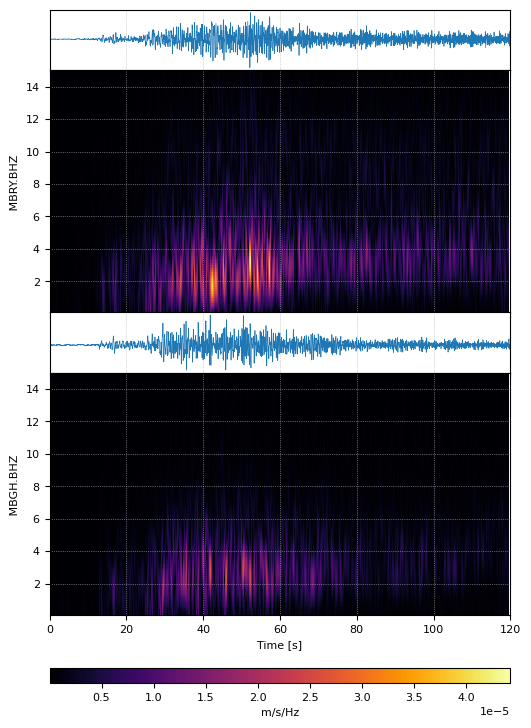

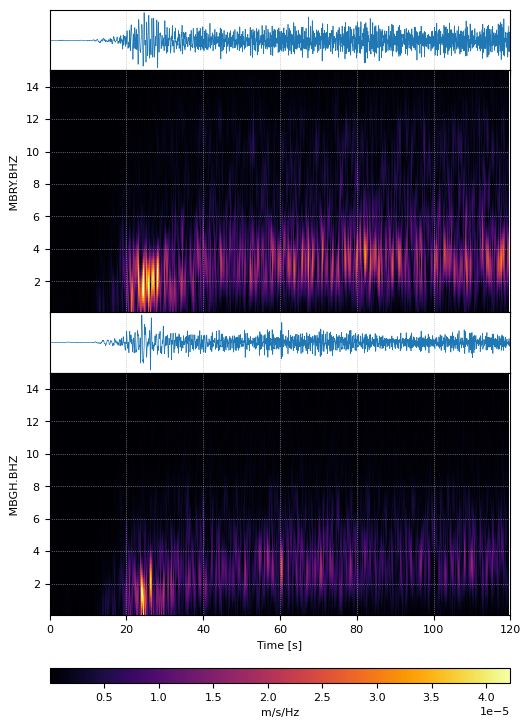

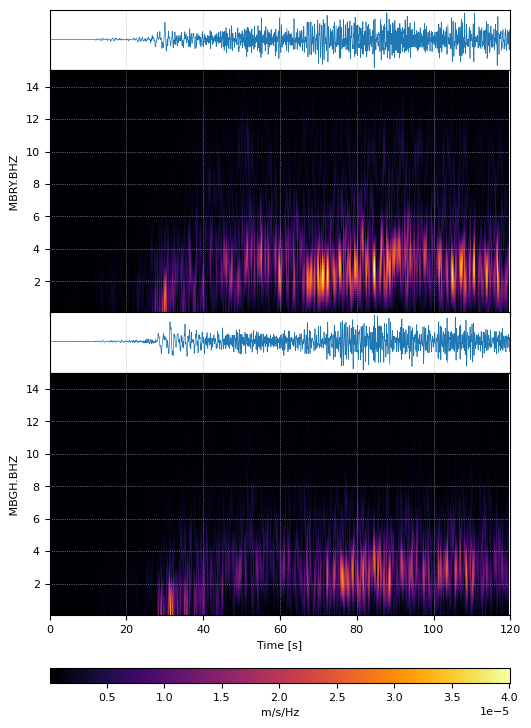

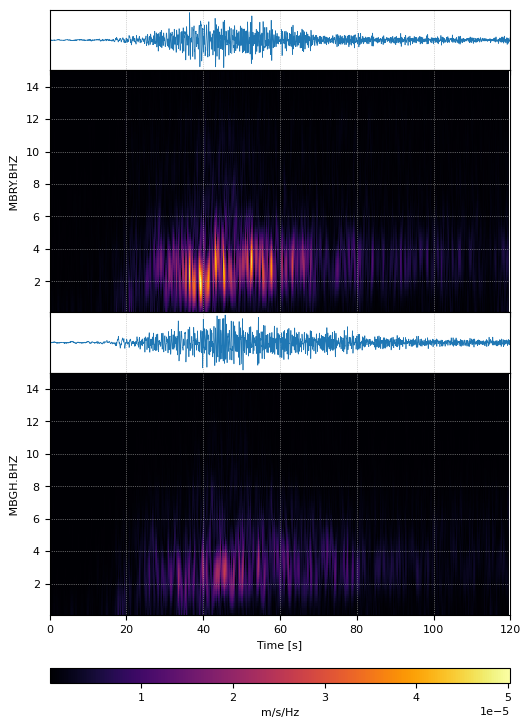

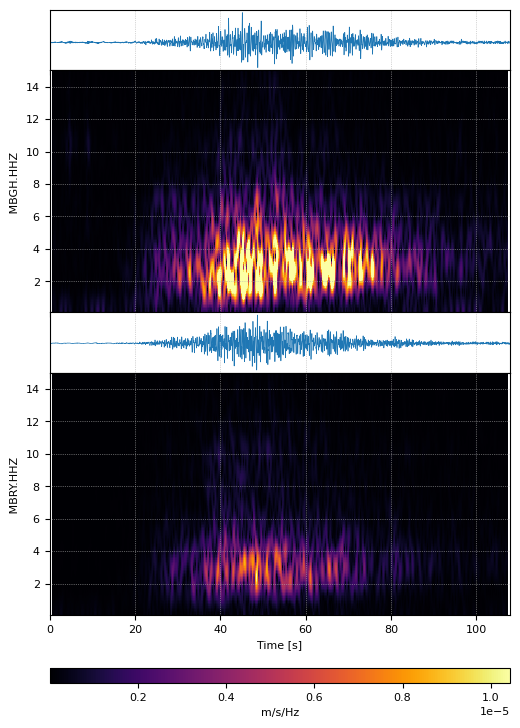

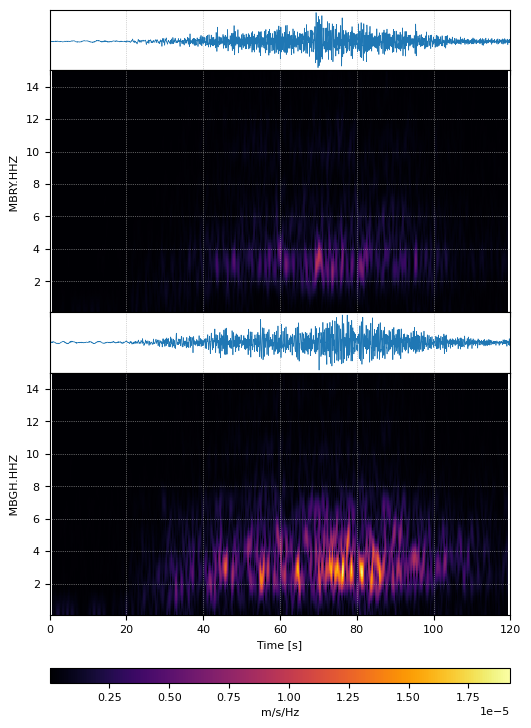

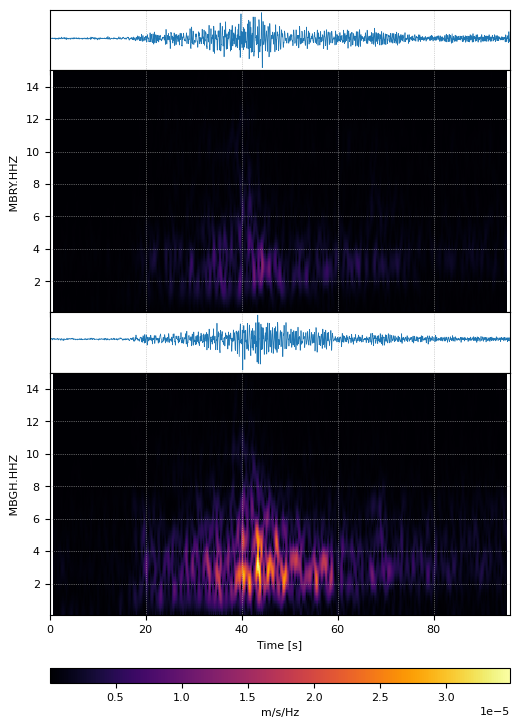

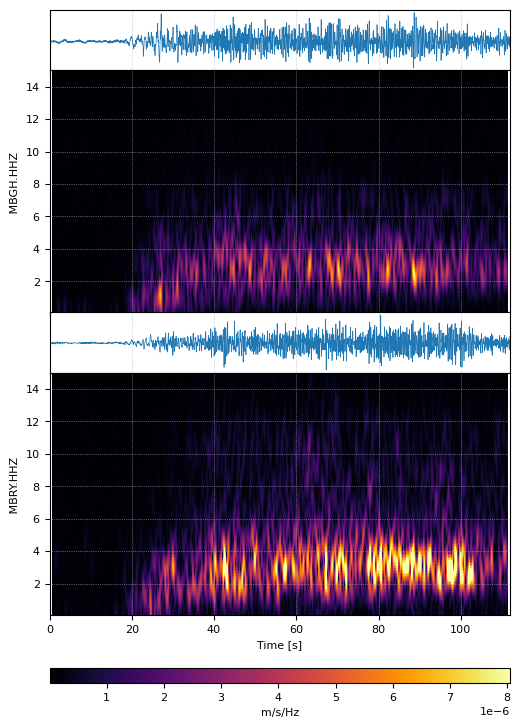

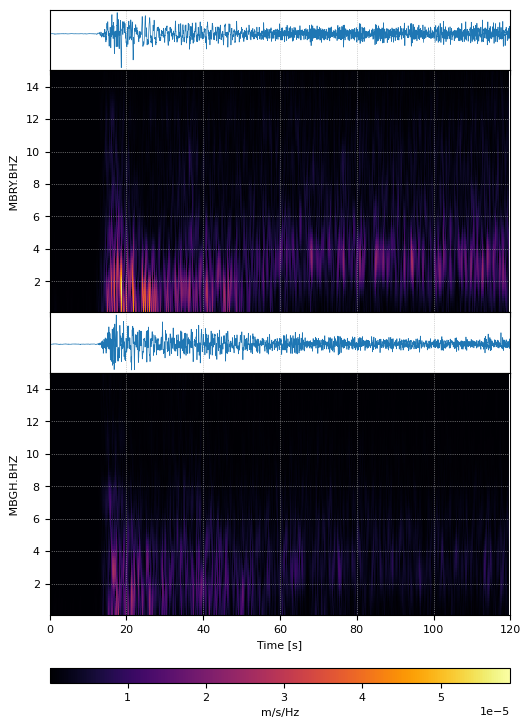

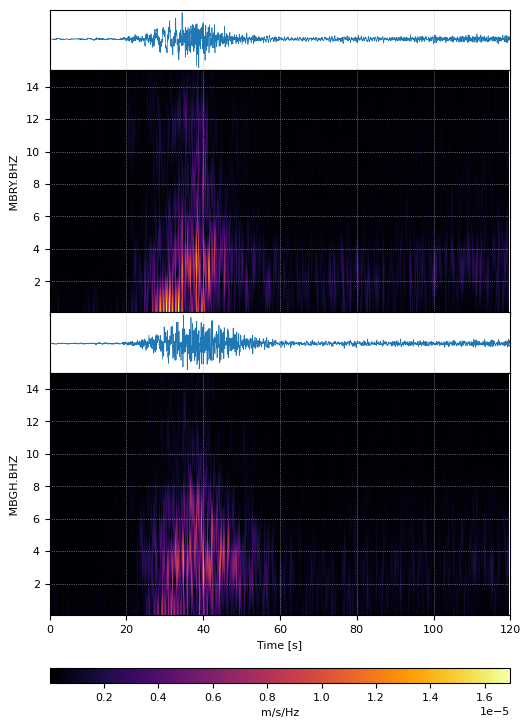

In [24]:
from flovopy.processing.spectrograms import icewebSpectrogram
from obspy import read
for mseed in best_event_files:
    st = read(mseed).select(component='Z')
    etime = min((st[0].stats.starttime+120, st[0].stats.endtime))
    st.trim(endtime=etime)
    st.traces = [tr for tr in st if tr.stats.station in ['MBRY', 'MBGH']]
    #st.spectrogram(log=False, dbscale=False, axes=None, title='Spectrogram', cmap='inferno', show=True)
    spobj = icewebSpectrogram(st, secsPerFFT=1)
    spobj.plot(log=False, dbscale=False, cmap='inferno', fmin=0.1, fmax=15.0, equal_scale=True)#, clim=[3e-7, 3e-5], )
